In [1]:
library(tidyverse)
library(rsample)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### Introduction

A computer science research group at UBC created a replica Minecraft server named Plaicraft, with the goal of collecting data that evaluates how people play video games. All players were volunteers. The researchers were able to collect data for each player that identified various characteristics such as their age, gender expression, and level of previous Minecraft experience, and they then tied that (using an anonymous id) to the number of cumulative hours each player had spent playing Plaicraft at the time of data collection. This project intends to determine whether certain demographics of age and experience level are more likely to contribute a large amount of data, and furthermore whether a satisfactory model can be created to predict the number of hours played (response variable) a certain player will contribute based on these two variables. We believe that this sort of predictive model will benefit researchers when trying to recruit active participants to the Plaicraft server.

In order to achieve this goal, we have decided to use the “players.csv” dataset (196 rows, 9 columns). This datatable appears tidy, as each row represents the data for one player, and each column represents a different variable. The nine different variables included are:

`experience` (type: character)
Players' self-reported level of Minecraft experience at the time of registering (categorical values, e.g. "Veteran").

`age` (type: double)
Players self-reported age (numerical value).

`subscribe` (type: logical) 
Whether or not users have agreed to subscribe to email notifications regarding server activity at the time of registering (two possible values: TRUE or FALSE).

`hashedEmail` (type: character)
Players' emails are encrypted to identify them anomalously within the dataset.

`played_hours` (type: double)
Cumulative number of hours a player has played at the time of data collection (numerical variable).

`name` (type: character)
Players' chosen pseudonym.

`gender` (type: character)
Players self-reported gender (categorical values, e.g. "Female")

`individualId` (type: logical) 
Empty (no data).

`organizationName` (type: logical) 
Empty (no data).

We are only interested in the first two variables listed: experience and age. This is because we later intend to use a knn regression-line model and thus require our explanatory variables to be numerical. Age is already a numerical variable, and level of experience is one of the only other variables that can reasonably be converted to a numerical variable (it can be treated as a scale, whereas other variables like gender cannot be interpreted as an objective scale). We did not want to include variables such as "subscribe", that occur upon registration and therefore cannot be used to inform recruitment decisions. Thus, our first step to wrangle our data was to select only for player_hours, experience, and age. And to convert experience to double value.

### Wrangling Data

In [2]:
library(tidyverse)
library(tidymodels)


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Search for functions across packages at https://www.tidymodels.org/find/



In [3]:
#load in data
googleplayers <- 'https://drive.google.com/file/d/1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz/edit'

#Turn google drive link into a direct link to load in the data
direct_link_players <- 'https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz'

players <- read_csv(direct_link_players)

head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [4]:
players_tidy <- players |> 
mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")) |> 
       unclass()) |> 
select(experience, played_hours, age) 
head(players_tidy)

experience,played_hours,age
<int>,<dbl>,<dbl>
4,30.3,9
5,3.8,17
5,0.0,17
2,0.7,21
3,0.1,21
2,0.0,17


In [5]:
set.seed(1234)
data_split <- initial_split(players_tidy, prop = .75, strata = played_hours) 
players_training <- training(data_split) 
players_testing <- testing(data_split) 

### Summary and Exploratory Visualization

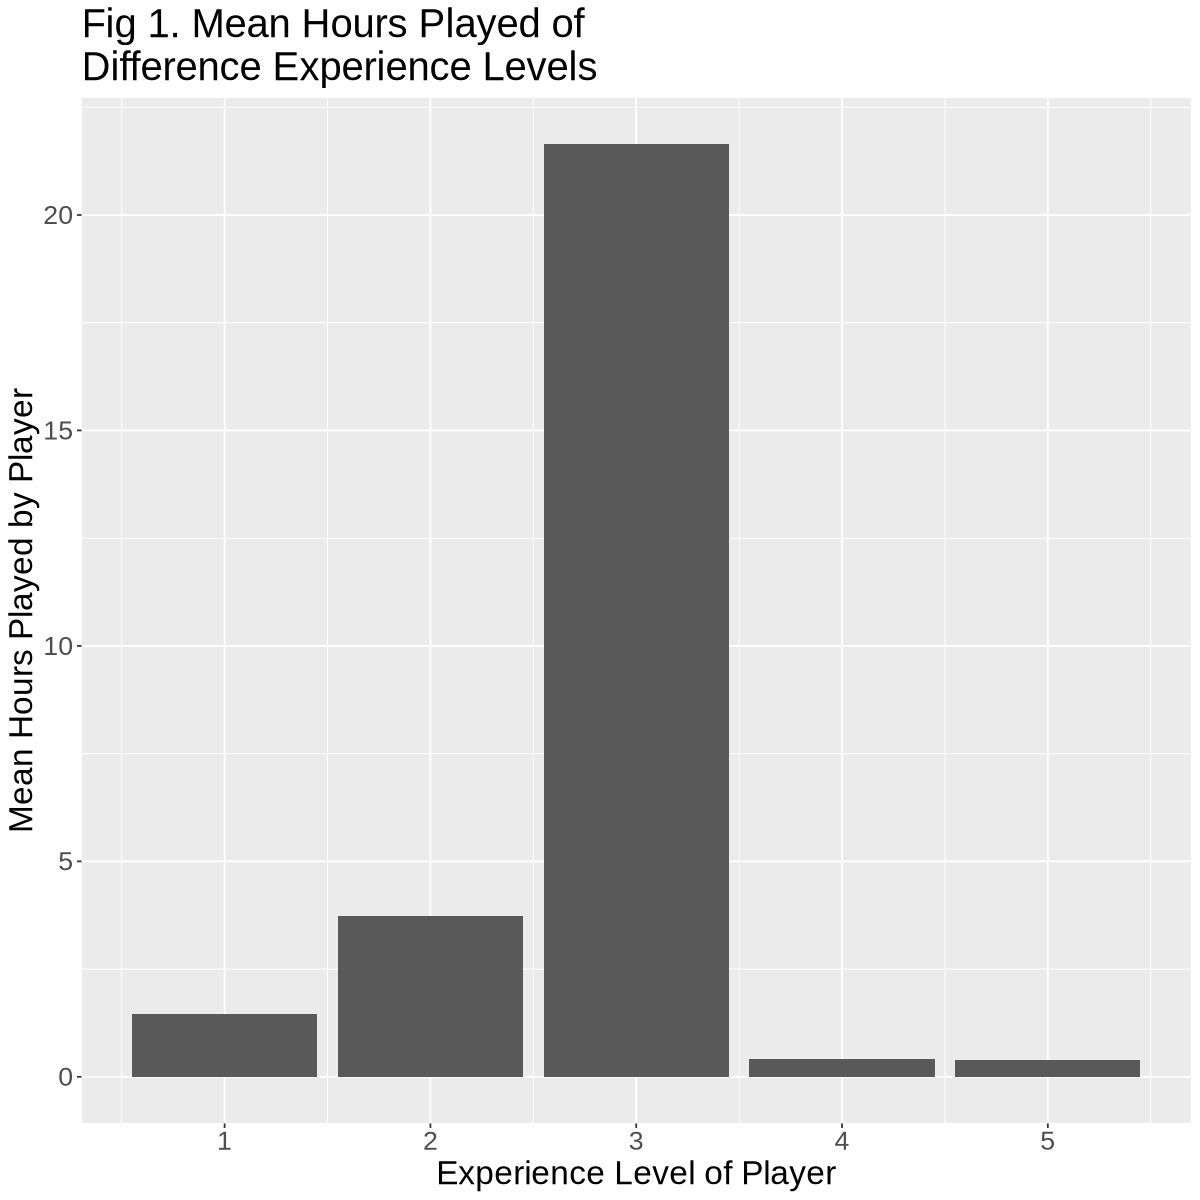

In [6]:
#graphing the amount of mean hours played by the different experience leveled players 
options(repr.plot.width = 10, repr.plot.height = 10) 

exp_hours_mean <- players_training|>
group_by(experience)|>
summarize(mean_exp = mean(played_hours))

players_h_vs_exp<- exp_hours_mean|>
                   ggplot(aes(x = experience, y = mean_exp))+
                   ggtitle("Fig 1. Mean Hours Played of \nDifference Experience Levels")+
                   geom_bar(stat = "identity")+
                   labs( x = "Experience Level of Player", y = "Mean Hours Played by Player") +
                   theme(text = element_text(size = 20))
players_h_vs_exp

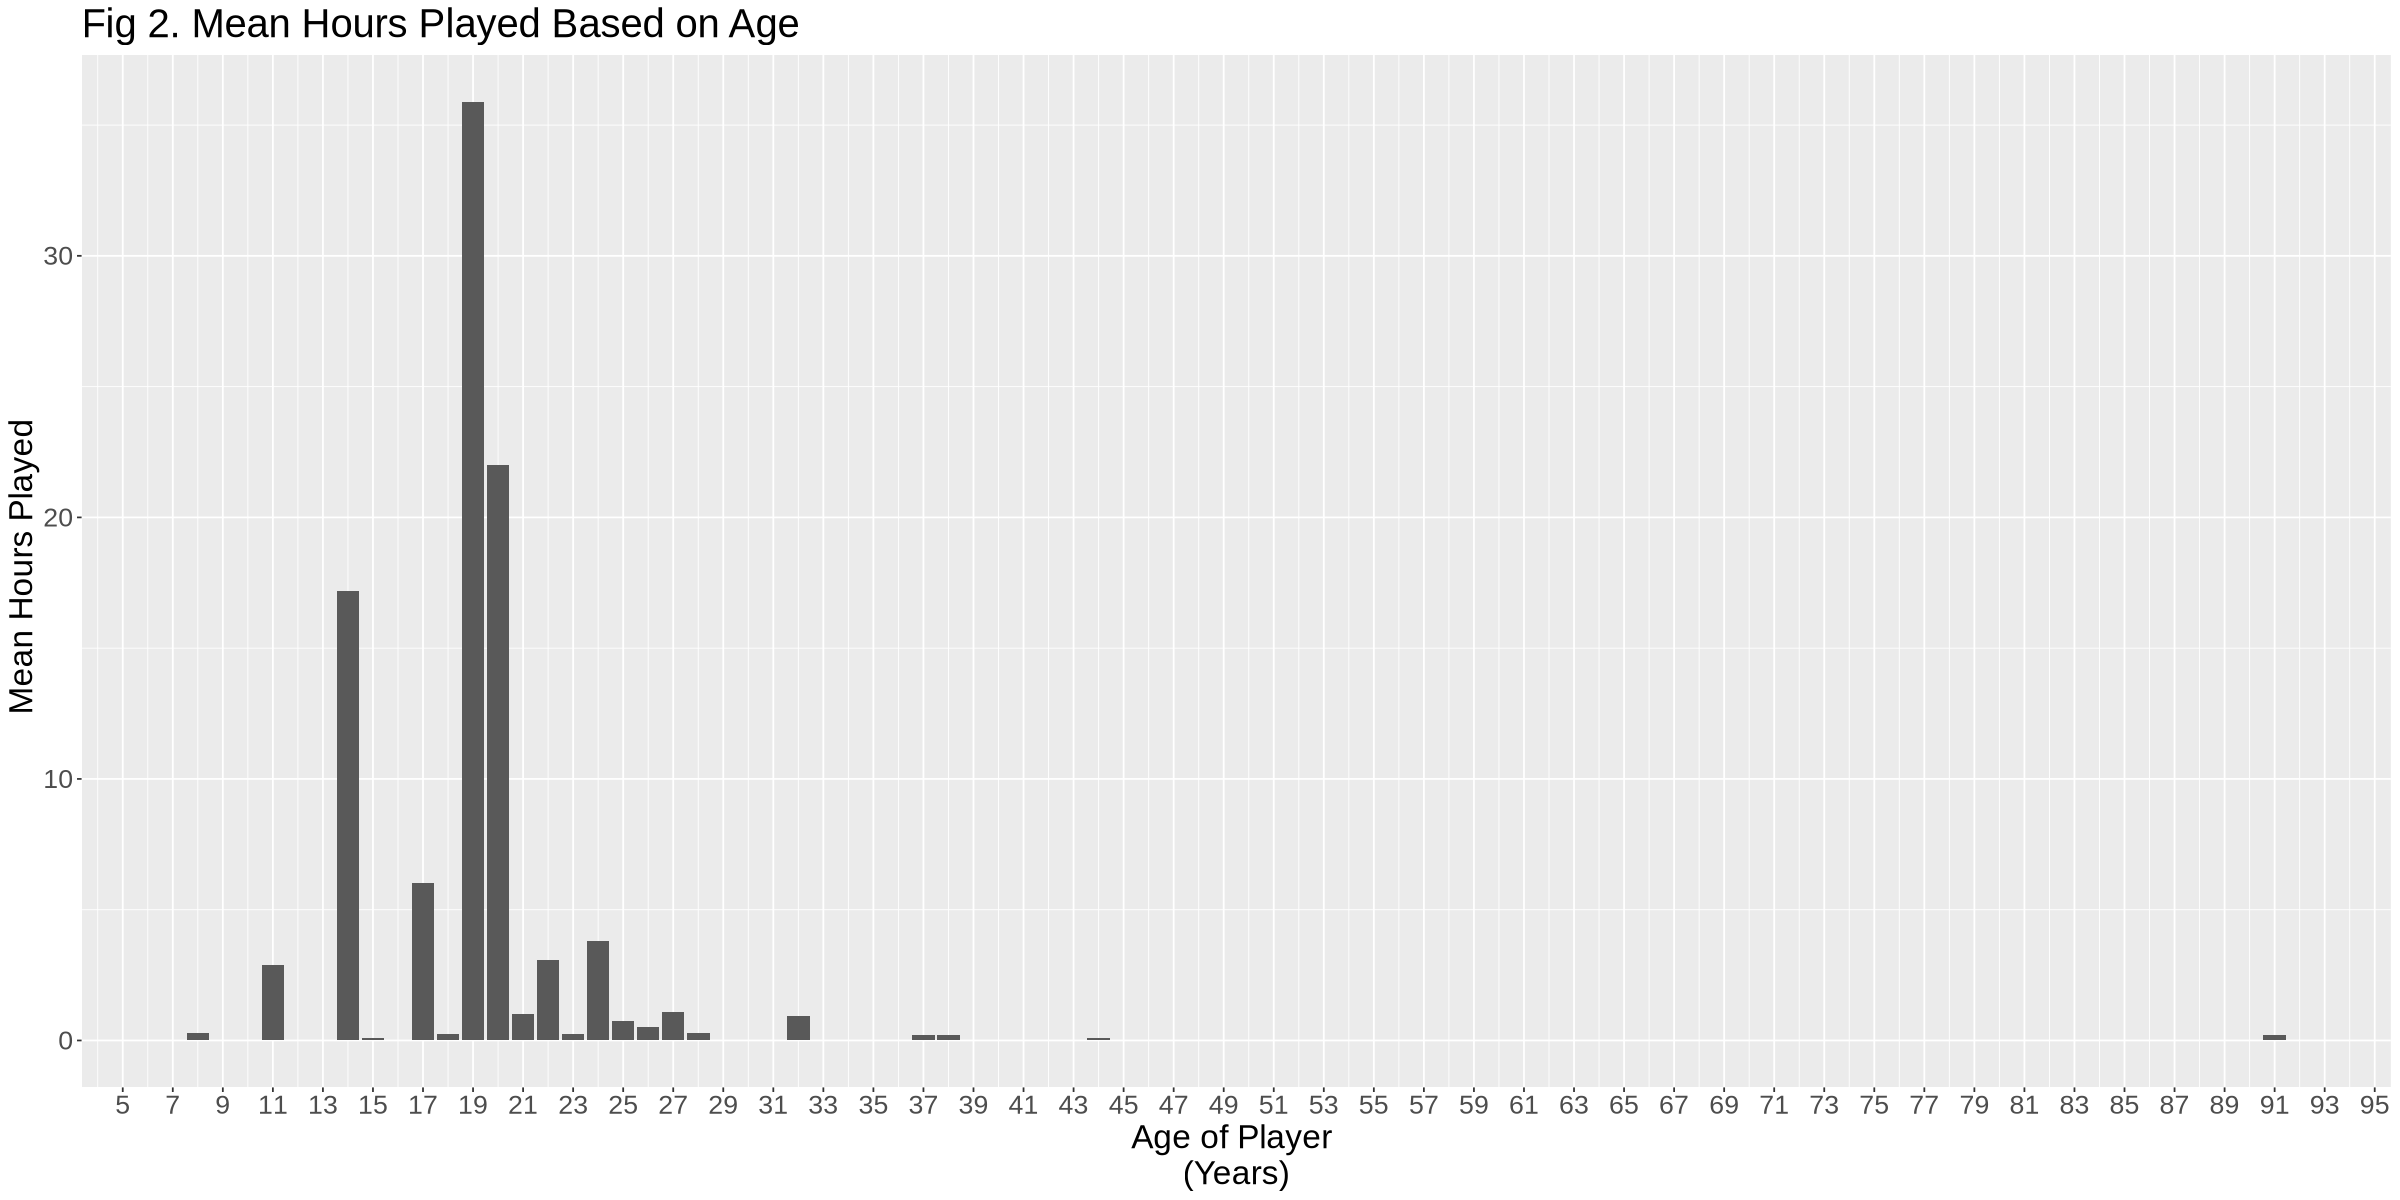

In [7]:
#graphing the amount of mean hours played by the different aged players 
options(repr.plot.width = 20, repr.plot.height = 10)

age_hours_mean <- players_training|>
group_by(age)|>
summarize(mean_age = mean(played_hours))
players_h_vs_age<- age_hours_mean|>
                   ggplot(aes(x = age, y = mean_age))+
                   ggtitle("Fig 2. Mean Hours Played Based on Age")+
                   geom_bar(stat = "identity")+
                   labs( x = "Age of Player \n(Years)", y = " Mean Hours Played")+
                   theme(text = element_text(size = 20))+
                   scale_x_continuous(breaks = seq(1,100, by = 2)) 
players_h_vs_age

### Data Analysis

### KNN-REGRESSION CODE W/ EXPERIENCE AS PREDICTOR


→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
16,rmse,standard,25.29465,5,8.334938,Preprocessor1_Model16


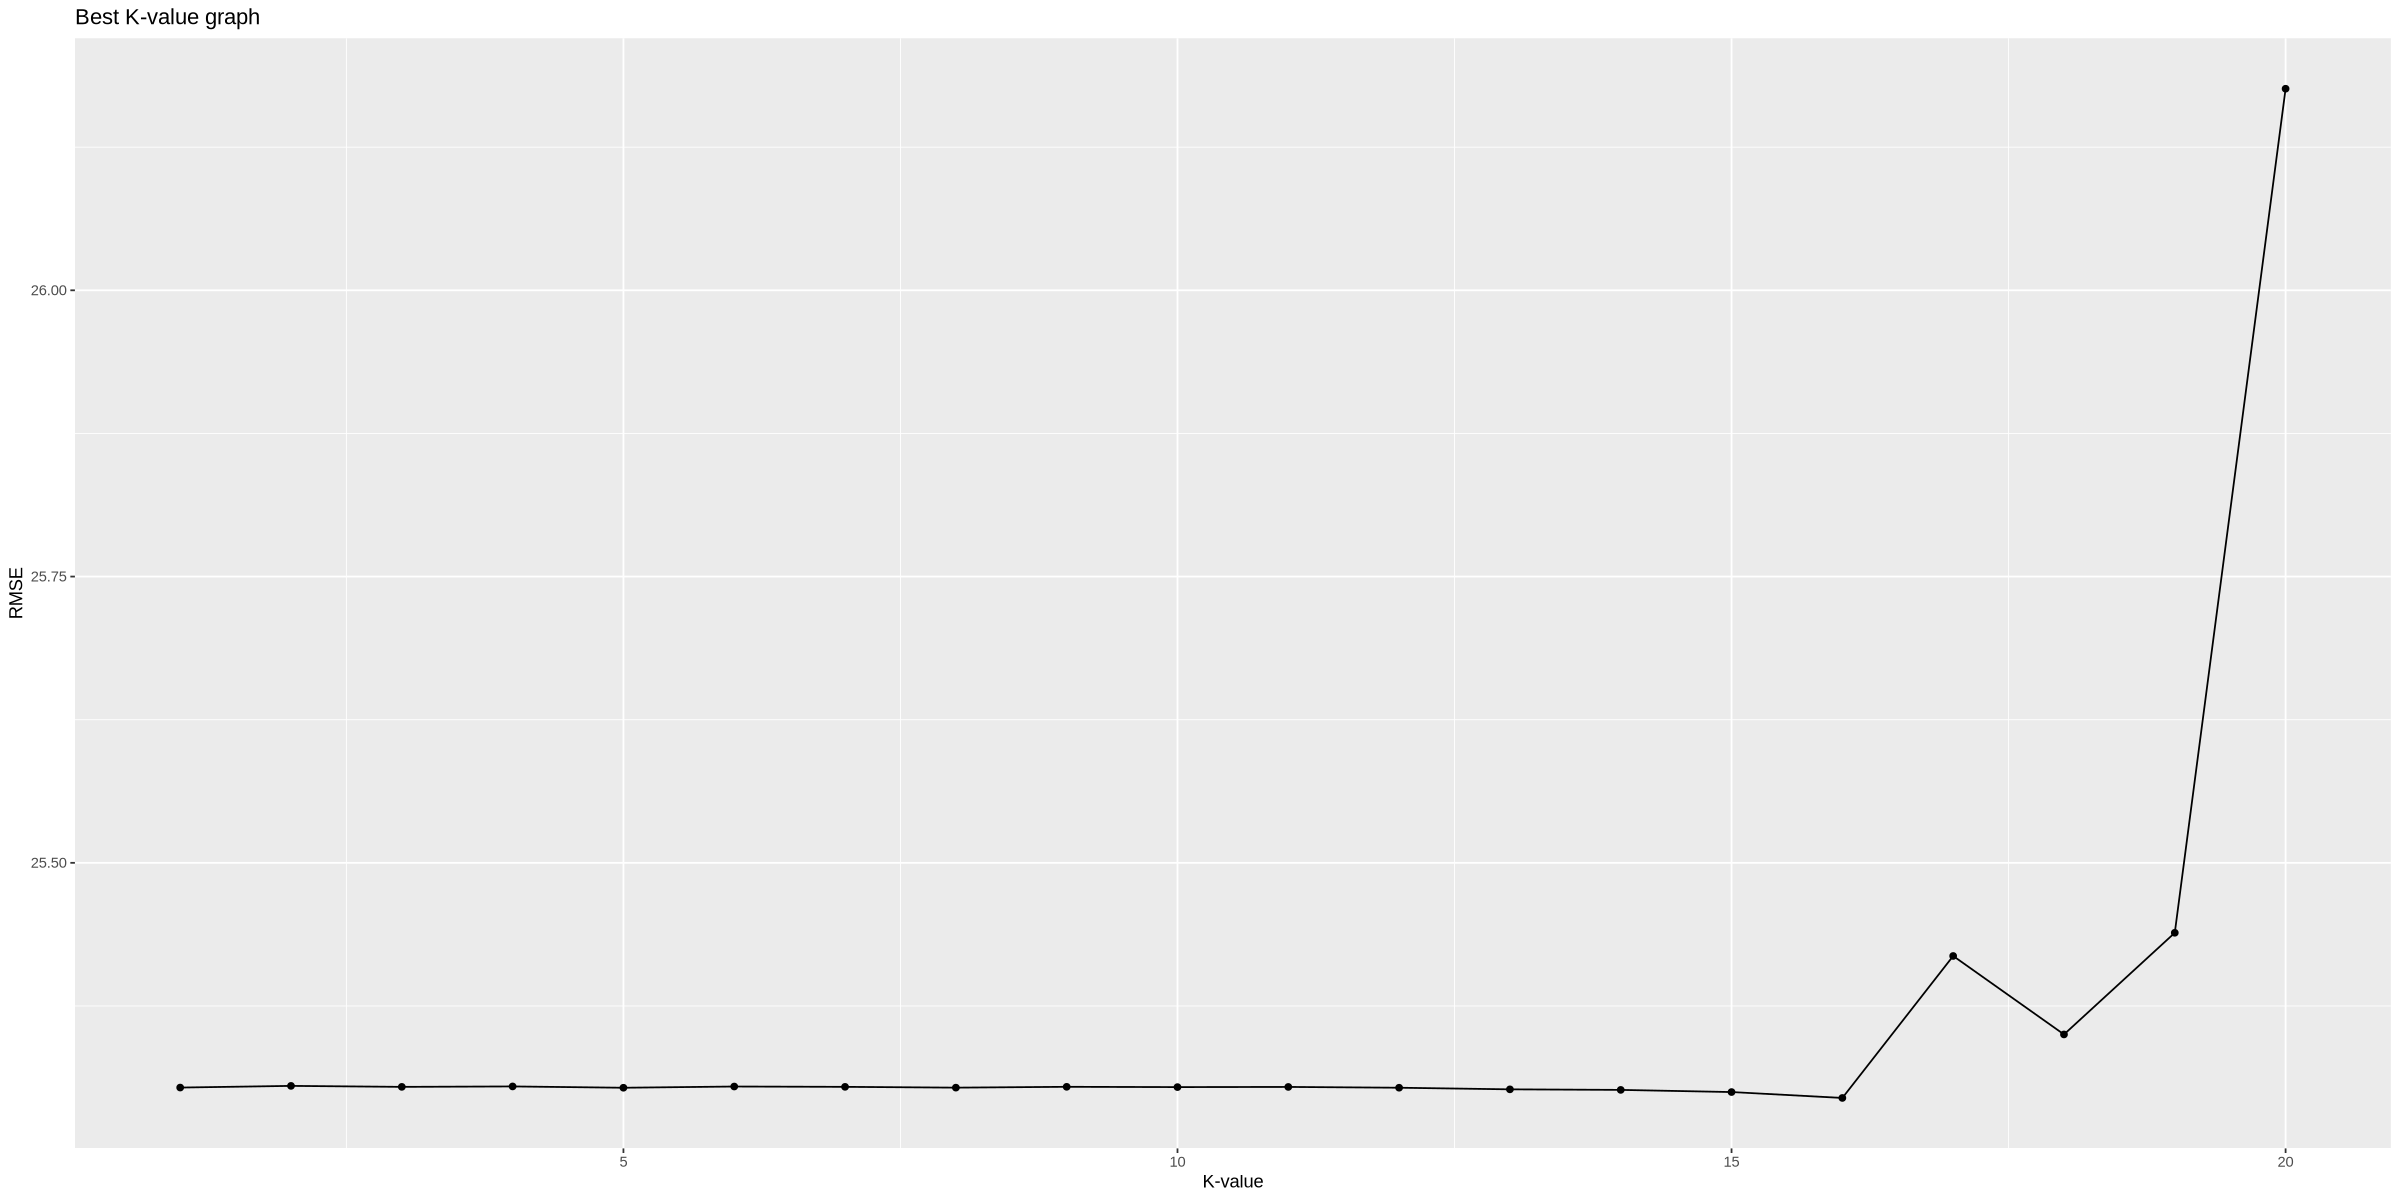

In [14]:
set.seed(1234)

# KNN-REGRESSION MODEL
players_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune())|>
    set_engine('kknn')|>
    set_mode('regression')

# CROSS VALIDATION
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)
k_values <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

#RECIPE
experience_recipe <- recipe(played_hours ~ experience, data = players_training) |> 
step_scale(all_predictors()) |> 
step_center(all_predictors())

# WORKFLOW

experience_knn_workflow <- workflow() |>
    add_model(players_spec)|>
    add_recipe(experience_recipe)

experience_tuning <- experience_knn_workflow |>
    tune_grid(resamples = players_vfold, grid = k_values)|>
    collect_metrics()

best_experience_k <- experience_tuning |>
    filter(.metric == 'rmse')|>
    slice_min(mean, n = 1) 

best_experience_k_viz <- experience_tuning |> 
filter(.metric == 'rmse') |> 
ggplot(aes(x = neighbors, y = mean)) + 
geom_point() + 
geom_line(aes(x = neighbors, y = mean)) + 
labs(x = "K-value", y = "RMSE") + 
ggtitle("Best K-value graph")

best_experience_k
best_experience_k_viz

# The result for tuning for the best K was when K = 16 with an RMSE of 25.29465
# NEW !! The result for tuning for the best K was when K = 18 with an RMSE of 19.79197
# The data is skewed in a lot of ways--need to talk about this

best_experience_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 16)|>
    set_engine('kknn')|>
    set_mode('regression')

experience_fit <- workflow()|>
    add_recipe(experience_recipe)|>
    add_model(best_experience_spec)|>
    fit(players_training)

## PREDICTED DATA TIBBLE

In [15]:
experience_preds <- experience_fit |>
    predict(players_testing)|>
    bind_cols(players_testing)|>
    arrange(desc(.pred))
head(experience_preds)

.pred,experience,played_hours,age
<dbl>,<int>,<dbl>,<dbl>
0.27500,4,30.3,9
0.27500,4,1.2,17
0.27500,4,0.5,12
0.27500,4,0.2,17
0.03125,5,1.6,23
0.03125,2,0.2,22


### KNN-REGRESSION CODE W/ AGE AS PREDICTOR

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,20.27317,10,7.726494,Preprocessor1_Model03


.pred,experience,played_hours,age
<dbl>,<int>,<dbl>,<dbl>
6.8000000,4,30.3,9
6.8000000,3,3.6,10
6.7333333,4,0.5,12
5.8000000,3,0.2,14
0.7333333,5,12.5,27
0.5333333,5,1.4,25


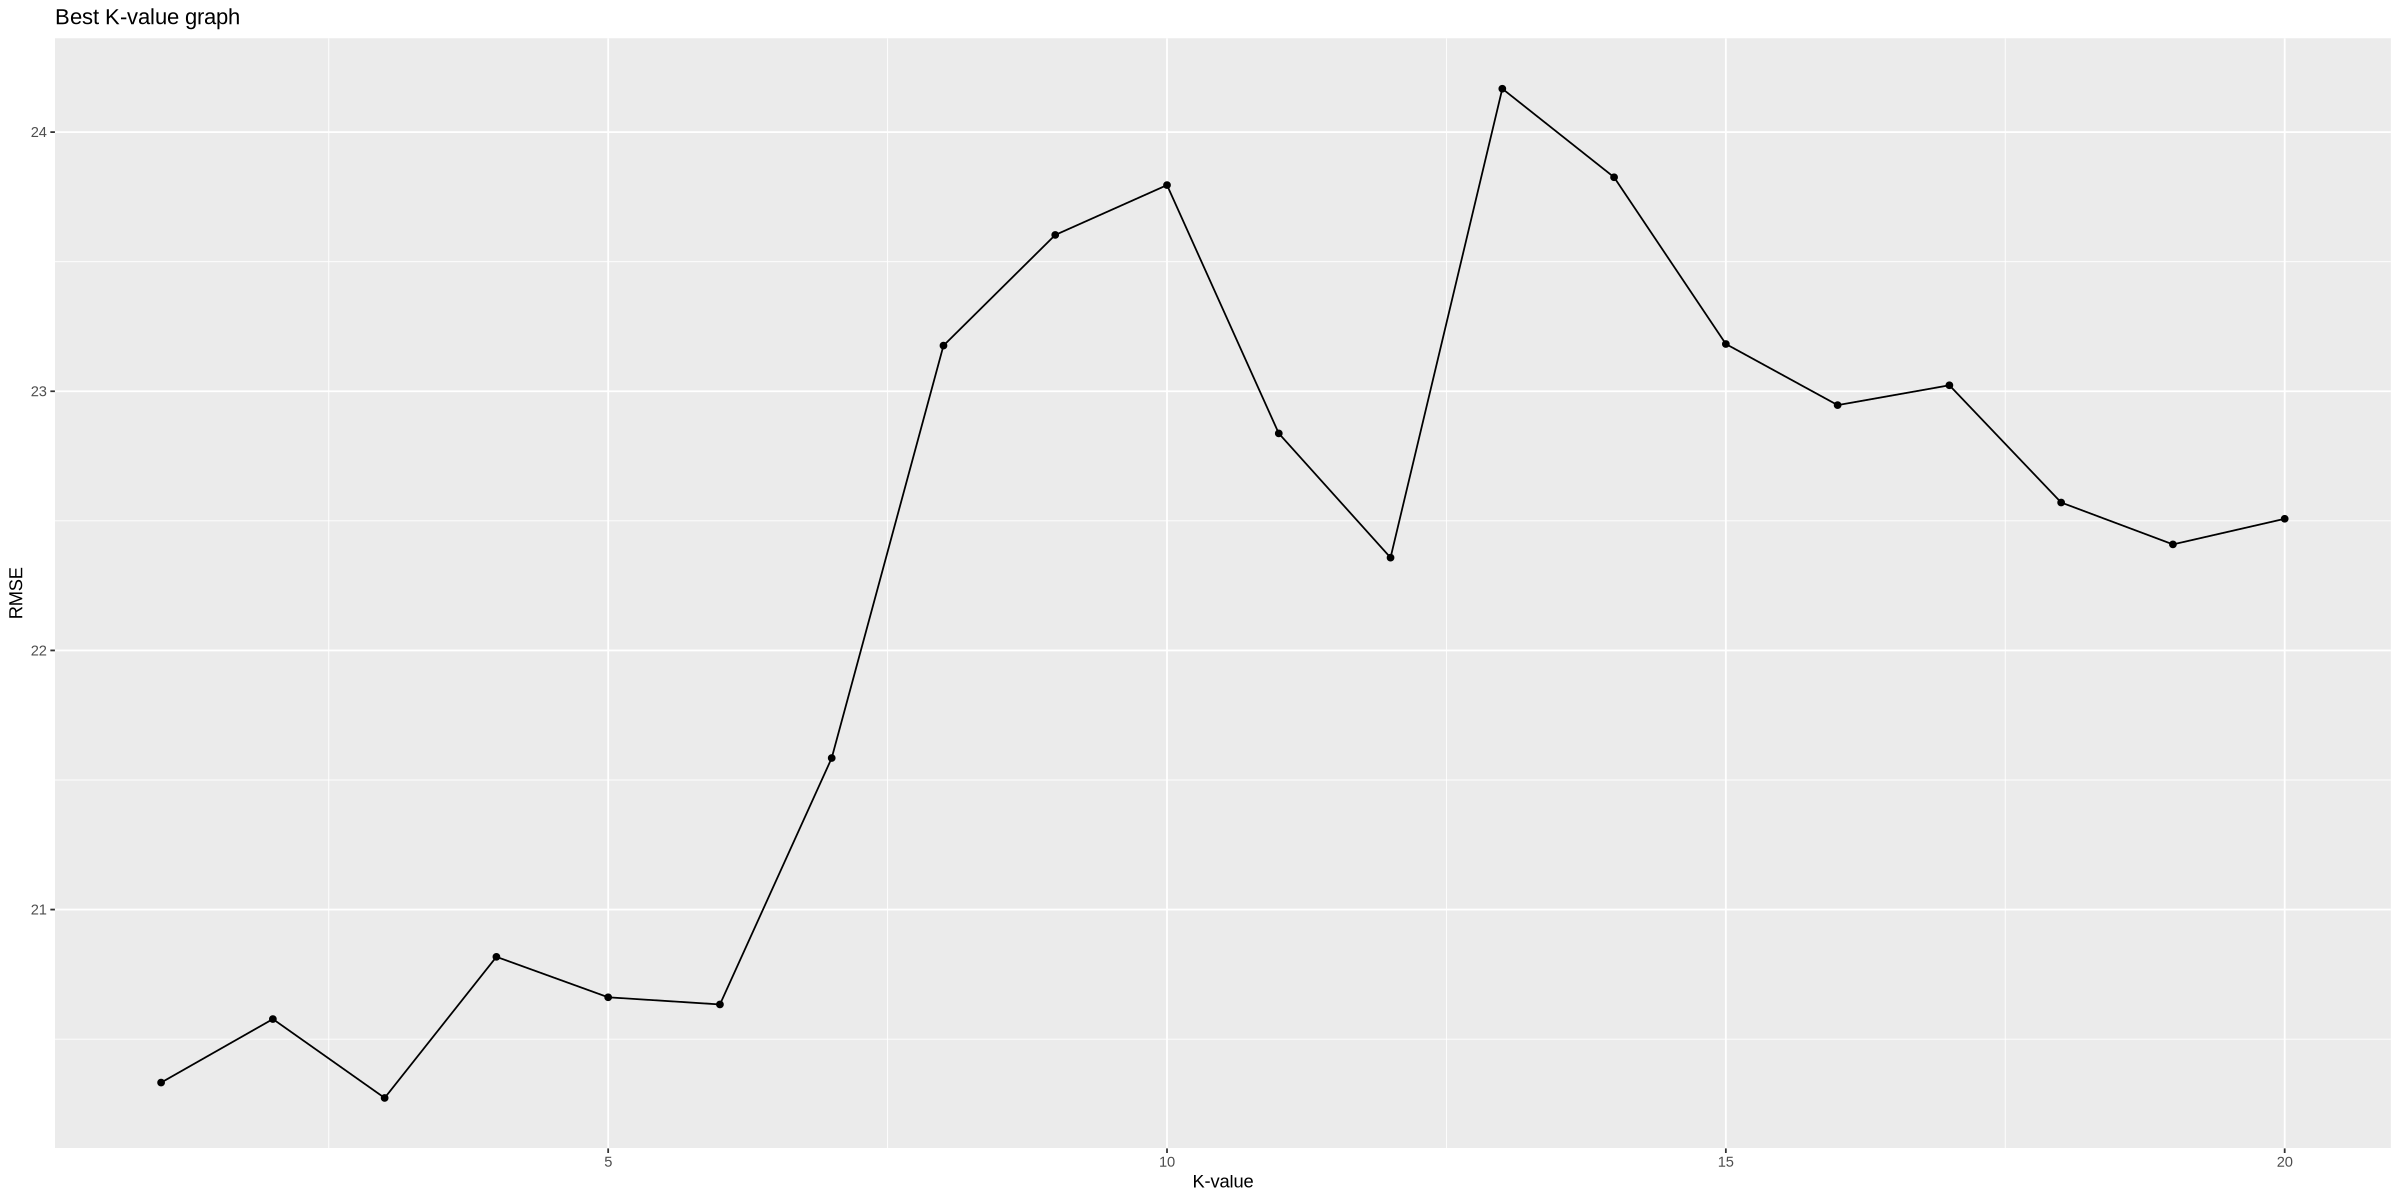

In [22]:
set.seed(1234)

# KNN-REGRESSION MODEL: AGE
players_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune())|>
    set_engine('kknn')|>
    set_mode('regression')

# CROSS VALIDATION
players_vfold <- vfold_cv(players_training, v = 10, strata = played_hours)
k_values <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

#RECIPE
age_recipe <- recipe(played_hours ~ age, data = players_training) |> 
step_scale(all_predictors()) |> 
step_center(all_predictors())

# WORKFLOW

age_knn_workflow <- workflow() |>
    add_model(players_spec)|>
    add_recipe(age_recipe)

age_tuning <- age_knn_workflow |>
    tune_grid(resamples = players_vfold, grid = k_values)|>
    collect_metrics()

best_age_k <- age_tuning |>
    filter(.metric == 'rmse')|>
    slice_min(mean, n = 1) 

best_age_k_viz <- age_tuning |> 
filter(.metric == 'rmse') |> 
ggplot(aes(x = neighbors, y = mean)) + 
geom_point() + 
geom_line(aes(x = neighbors, y = mean)) + 
labs(x = "K-value", y = "RMSE") + 
ggtitle("Best K-value graph")

best_age_k
best_age_k_viz

# Best value is 3 w/ rmse 20.27317

new_age_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 3)|>
    set_engine('kknn')|>
    set_mode('regression')

age_fit <- workflow()|>
    add_recipe(age_recipe)|>
    add_model(new_age_spec)|>
    fit(players_training)

age_preds <- age_fit |>
    predict(players_testing)|>
    bind_cols(players_testing)|>
    arrange(desc(.pred))
head(age_preds)

### PROBLEMS WITH DRAWING A CONCLUSION WITH PREDICTIVE DATA
Due to the dataset, we faced problems being able to come to a conclusion based on the predictive model. To  minimize errors with KNN regression, we chose to build one model at a time, using only one explanatory variable and one response variable. In the model above, the predictor is `experience` and the predicted variable is `played_hours`. However, looking at our predicted results we can see that the predictions are far off from the true results. The RMSPE `(insert RMPSE value here)` also tells us that the range of error is quite large, especially when predicting played time.

We believe this is the case because the data reported from the players is extremely skewed. If you take a look at the full data sheet for `players` then you'll notice that some players have over 10 hours logged, whereas some (at least a quarter of the observations) have less than an hour or even 0. The predictive model attempts to find a middle ground between the two, but ultimately fails to do a good job of predicting because there are so many "outlier" cases and the observations don't have a clear median.

Therefore, we consider our predictive model unsuccessful. Presented with a larger data set with more observations, a predictive model using KNN regression would have likely been successful. But there are some difficulties that this specific dataset presents that make it hard for us to present a trustworthy conclusion. Instead, we would recommend building a predictive model when the dataset is suitable because it is still an appropriate way to gauge how many hours the research participants will contribute, but the training data will have to be less skewed to the extremes. To better answer what demographics the computer science research team should target, it is easier to look at the current history and draw conclusions based on the visualization of data.

#### Discussion ####

While the size and quality of the dataset meant that it was somewhat difficult to create a highly accurate predictive model (e.g. there were a lot of data points for certain ages and then almost none for most of the others), the predictive model, and especially the exploratory visualizations could be helpful to the research group as it is clear to see that players aged 19-20 and those with a regular amount of experience had the highest mean amount of played hours when compared to other ages and levels of experience respectively. Thus, the research group should consider this knowledge when attempting to recruit new volunteer players, as it may be more worthwhile for them to specifically target the 19-20 age demographic, and individuals with a regular amount of experience.

They could create posters that are specifically designed to attract these age and experience level demographics. If they do so, it would be interesting to evaluate the effectiveness of this marketing strategy by implementing these targeted posters and then later, a couple weeks/months after, calculating the mean number of hours played for all players to see if there was any overall improvement in participant activity. Additionally, before actually implementing targeted marketing, it might be worthwhile to evaluate if players aged 19-20 or those who have a regular amount of experience, are actually more likely to contribute more hours on the long run. The researchers could explore the correlation between length of active participation of volunteers (time passed between their first session and latest session), and age and experience level (this way they could see if 19-20 year olds just play more hours in the short-run then lose commitment later).
